In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date

power_df = pd.read_csv("combined_power_log.CSV", encoding="iso-8859-1")
power_df = power_df.iloc[:-2]
power_df = power_df[["Date", "Time", "CPU Package Power [W]", "Total CPU Usage [%]"]]

power_df = power_df.rename(columns={
    "Date": "date_str",
    "Time": "timestamp",
    "CPU Package Power [W]": "power",
    "Total CPU Usage [%]": "cpu_usage"
})

power_df["unix_time"] = power_df.apply(
    lambda row: datetime.strptime(
        f"{row['date_str']} {row['timestamp']}", "%d.%m.%Y %H:%M:%S.%f"
    ).timestamp(),
    axis=1
)

power_df['power'] = pd.to_numeric(power_df['power'], errors='coerce')
power_df['cpu_usage'] = pd.to_numeric(power_df['cpu_usage'], errors='coerce')

power_df = power_df.sort_values("unix_time").reset_index(drop=True)
power_df["delta_t"] = power_df["unix_time"].diff().shift(-1).fillna(0)
power_df["energy_j"] = power_df["power"] * power_df["delta_t"]

C:\Users\ASUS\AppData\Local\Temp\ipykernel_21176\3385664453.py:5: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54) have mixed types. Specify dtype option on import or set low_memory=False.
  power_df = pd.read_csv("combined_power_log.CSV", encoding="iso-8859-1")


In [2]:
power_df.head()

,date_str,timestamp,power,cpu_usage,unix_time,delta_t,energy_j
0,26.11.2025,6:7:15.257,13.635,36.6,1.764108e+09,0.025,0.340876
1,26.11.2025,6:7:15.282,17.633,63.5,1.764108e+09,0.085,1.498806
2,26.11.2025,6:7:15.367,17.633,63.5,1.764108e+09,0.117,2.063059
3,26.11.2025,6:7:15.484,13.371,25.1,1.764108e+09,0.108,1.444069
4,26.11.2025,6:7:15.592,11.016,29.7,1.764108e+09,0.102,1.123632


# Sequential

In [3]:
sequential_df = pd.read_csv("sequential_results.CSV")
sequential_df['startTime'] = pd.to_datetime(sequential_df['startTime']).apply(lambda t: t.timestamp())
sequential_df['endTime'] = pd.to_datetime(sequential_df['endTime']).apply(lambda t: t.timestamp())

sequential_df.head()

,solverType,threads,isParallel,boardSize,domainGranularity,startTime,endTime,firstSolutionTime,timeToFirst,timeToAll,cpuTime,peakMemoryMB,numberOfSolutions
0,BT,1,0,8,1,1.764108e+09,1.764108e+09,2025-11-25T22:07:21.218Z,0.000053,0.000604,0.0,5.02734,92
1,BT,1,0,8,1,1.764108e+09,1.764108e+09,2025-11-25T22:07:21.244Z,0.000055,0.000631,0.0,5.30859,92
2,BT,1,0,8,1,1.764108e+09,1.764108e+09,2025-11-25T22:07:21.258Z,0.000064,0.000900,0.0,5.39453,92
3,BT,1,0,8,1,1.764108e+09,1.764108e+09,2025-11-25T22:07:21.273Z,0.000048,0.000592,0.0,5.42188,92
4,BT,1,0,8,1,1.764108e+09,1.764108e+09,2025-11-25T22:07:21.290Z,0.000078,0.000817,0.0,5.42578,92


In [4]:
mean_power = []
std_power = []
max_power = []

mean_usage = []
std_usage = []
max_usage = []

sum_energy = []

measurement_counts = []

for _, row in sequential_df.iterrows():
    start = row["startTime"]
    end = row["endTime"]

    mask = (power_df["unix_time"] >= start) & (power_df["unix_time"] <= end)
    rows = power_df.loc[mask, ["power", "cpu_usage", "energy_j"]]

    mean_power.append(rows["power"].mean())
    std_power.append(rows["power"].std())
    max_power.append(rows["power"].max())

    mean_usage.append(rows["cpu_usage"].mean())
    std_usage.append(rows["cpu_usage"].std())
    max_usage.append(rows["cpu_usage"].max())

    sum_energy.append(rows["energy_j"].sum())
    
    measurement_counts.append(len(rows))
    
sequential_df["power_mean"] = mean_power
sequential_df["power_std"]  = std_power
sequential_df["power_max"]  = max_power
sequential_df["cpu_usage_mean"] = mean_usage
sequential_df["cpu_usage_std"]  = std_usage
sequential_df["cpu_usage_max"]  = max_usage
sequential_df["energy_sum"] = sum_energy
sequential_df["num_measurements"] = measurement_counts


In [5]:
sequential_summary_grouped_df = sequential_df.groupby(['solverType', 'threads', 'isParallel', 'boardSize', 'domainGranularity'])[['timeToFirst', 'timeToAll', 'cpuTime','peakMemoryMB', 'power_mean', 'cpu_usage_mean', 'energy_sum']].mean()

sequential_summary_grouped_df

timeToFirst  \
solverType threads isParallel boardSize domainGranularity                
AC3        1       0          8         1                     0.000052   
                              10        1                     0.000092   
                              12        1                     0.000154   
                              14        1                     0.001041   
                              16        1                     0.002520   
AC3-DVO    1       0          8         1                     0.000056   
                              10        1                     0.000087   
                              12        1                     0.000174   
                              14        1                     0.000344   
                              16        1                     0.000501   
BT         1       0          8         1                     0.000054   
                              10        1                     0.000057   
                              12        1                     0.000114   
                              14        1                     0.000844   
                              16        1                     0.004677   
BT-FC      1       0          8         1                     0.000056   
                              10        1                     0.000084   
                              12        1                     0.000120   
                              14        1                     0.000635   
                              16        1                     0.003045   
BT-FC-DVO  1       0          8         1                     0.000060   
                              10        1                     0.000062   
                              12        1                     0.000128   
                              14        1                     0.000161   
                              16        1                     0.000205   

                                                            timeToAll  \
solverType threads isParallel boardSize domainGranularity               
AC3        1       0          8         1                    0.000600   
                              10        1                    0.007849   
                              12        1                    0.162738   
                              14        1                    6.440860   
                              16        1                  264.875600   
AC3-DVO    1       0          8         1                    0.000618   
                              10        1                    0.008121   
                              12        1                    0.178321   
                              14        1                    6.895250   
                              16        1                  288.331800   
BT         1       0          8         1                    0.000665   
                              10        1                    0.013109   
                              12        1                    0.297096   
                              14        1                   10.543860   
                              16        1                  516.834000   
BT-FC      1       0          8         1                    0.000635   
                              10        1                    0.009300   
                              12        1                    0.185762   
                              14        1                    7.256700   
                              16        1                  302.958800   
BT-FC-DVO  1       0          8         1                    0.000661   
                              10        1                    0.009704   
                              12        1                    0.192830   
                              14        1                    7.316052   
                              16        1                  287.320800   

                                                              cpuTime  \
solverType thre

# Testing domainGranularity

In [6]:
granularities_df = pd.read_csv("granularities_results.CSV")

granularities_df.head()

,solverType,threads,isParallel,boardSize,domainGranularity,startTime,endTime,firstSolutionTime,timeToFirst,timeToAll,cpuTime,peakMemoryMB,numberOfSolutions
0,AC3,6,1,16,1,2025-11-25T20:32:59.892Z,2025-11-25T20:33:42.384Z,2025-11-25T20:32:59.893Z,0.001297,42.4928,219.703,2954.96,14772512
1,AC3,6,1,16,1,2025-11-25T20:33:43.285Z,2025-11-25T20:34:27.297Z,2025-11-25T20:33:43.286Z,0.001725,44.0127,223.469,2962.48,14772512
2,AC3,6,1,16,1,2025-11-25T20:34:28.197Z,2025-11-25T20:35:12.001Z,2025-11-25T20:34:28.199Z,0.001654,43.8038,224.234,2962.53,14772512
3,AC3,6,1,16,1,2025-11-25T20:35:12.965Z,2025-11-25T20:35:57.176Z,2025-11-25T20:35:12.967Z,0.001563,44.2107,223.953,2963.50,14772512
4,AC3,6,1,16,1,2025-11-25T20:35:58.110Z,2025-11-25T20:36:42.176Z,2025-11-25T20:35:58.112Z,0.001634,44.0655,225.125,2963.82,14772512


In [7]:
granularities_df.groupby('domainGranularity')['timeToAll'].agg(['mean', 'std'])

,mean,std
domainGranularity,,
1,43.71710,0.699791
2,41.62030,1.689618
3,42.33782,0.299862


# Parallel

In [8]:
parallel_df = pd.read_csv("parallel_results.CSV")
parallel_df['startTime'] = pd.to_datetime(parallel_df['startTime']).apply(lambda t: t.timestamp())
parallel_df['endTime'] = pd.to_datetime(parallel_df['endTime']).apply(lambda t: t.timestamp())

parallel_df.head()

,solverType,threads,isParallel,boardSize,domainGranularity,startTime,endTime,firstSolutionTime,timeToFirst,timeToAll,cpuTime,peakMemoryMB,numberOfSolutions
0,BT,2,1,16,2,1.764104e+09,1.764104e+09,2025-11-25T20:50:47.653Z,0.004770,227.7340,448.438,3005.85,14772512
1,BT,2,1,16,2,1.764104e+09,1.764104e+09,2025-11-25T20:54:36.320Z,0.003612,266.7920,525.484,3005.36,14772512
2,BT,2,1,16,2,1.764104e+09,1.764105e+09,2025-11-25T20:59:04.305Z,0.005373,278.0880,547.141,3003.50,14772512
3,BT,2,1,16,2,1.764105e+09,1.764105e+09,2025-11-25T21:03:43.847Z,0.004268,275.2080,541.922,3007.29,14772512
4,BT,10,1,16,2,1.764105e+09,1.764105e+09,2025-11-25T21:11:05.419Z,0.001581,71.3244,644.219,2997.72,14772512


In [9]:
mean_power = []
std_power = []
max_power = []

mean_usage = []
std_usage = []
max_usage = []

sum_energy = []

measurement_counts = []

for _, row in parallel_df.iterrows():
    start = row["startTime"]
    end = row["endTime"]

    mask = (power_df["unix_time"] >= start) & (power_df["unix_time"] <= end)
    rows = power_df.loc[mask, ["power", "cpu_usage", "energy_j"]]

    mean_power.append(rows["power"].mean())
    std_power.append(rows["power"].std())
    max_power.append(rows["power"].max())

    mean_usage.append(rows["cpu_usage"].mean())
    std_usage.append(rows["cpu_usage"].std())
    max_usage.append(rows["cpu_usage"].max())

    sum_energy.append(rows["energy_j"].sum())
    
    measurement_counts.append(len(rows))
    
parallel_df["power_mean"] = mean_power
parallel_df["power_std"]  = std_power
parallel_df["power_max"]  = max_power
parallel_df["cpu_usage_mean"] = mean_usage
parallel_df["cpu_usage_std"]  = std_usage
parallel_df["cpu_usage_max"]  = max_usage
parallel_df["energy_sum"] = sum_energy
parallel_df["num_measurements"] = measurement_counts


In [10]:
parallel_summary_grouped_df = parallel_df.groupby(['solverType', 'threads', 'isParallel', 'boardSize', 'domainGranularity'])[['timeToFirst', 'timeToAll', 'cpuTime','peakMemoryMB', 'power_mean', 'cpu_usage_mean', 'energy_sum']].mean()
parallel_summary_grouped_df

timeToFirst  \
solverType threads isParallel boardSize domainGranularity                
AC3        2       1          16        2                     0.003516   
           4       1          16        2                     0.002786   
           6       1          16        2                     0.003304   
           8       1          16        2                     0.002881   
           10      1          16        2                     0.003182   
AC3-DVO    2       1          16        2                     0.001926   
           4       1          16        2                     0.002129   
           6       1          16        2                     0.001943   
           8       1          16        2                     0.002027   
           10      1          16        2                     0.002436   
BT         2       1          16        2                     0.004715   
           4       1          16        2                     0.002555   
           6       1          16        2                     0.002613   
           8       1          16        2                     0.002578   
           10      1          16        2                     0.002742   
BT-FC      2       1          16        2                     0.003586   
           4       1          16        2                     0.002759   
           6       1          16        2                     0.002850   
           8       1          16        2                     0.003984   
           10      1          16        2                     0.001931   
BT-FC-DVO  2       1          16        2                     0.000911   
           4       1          16        2                     0.000911   
           6       1          16        2                     0.001161   
           8       1          16        2                     0.001661   
           10      1          16        2                     0.001095   

                                                           timeToAll  \
solverType threads isParallel boardSize domainGranularity              
AC3        2       1          16        2                  133.08560   
           4       1          16        2                   72.40482   
           6       1          16        2                   49.21870   
           8       1          16        2                   39.04846   
           10      1          16        2                   36.86794   
AC3-DVO    2       1          16        2                  147.30200   
           4       1          16        2                   77.83712   
           6       1          16        2                   55.97898   
           8       1          16        2                   47.48410   
           10      1          16        2                   41.69616   
BT         2       1          16        2                  287.45710   
           4       1          16        2                  160.96100   
           6       1          16        2                  115.57100   
           8       1          16        2                   92.34920   
           10      1          16        2                   80.89021   
BT-FC      2       1          16        2                  174.52780   
           4       1          16        2                   99.38250   
           6       1          16        2                   75.23194   
           8       1          16        2                   64.55866   
           10      1          16        2                   58.41276   
BT-FC-DVO  2       1          16        2                  162.24160   
           4       1          16        2                   90.87990   
           6       1          16        2                   68.92688   
           8       1          16        2                   58.75992   
           10      1          16        2                   53.41222   

                                                            cpuTime  \
solverType threads isParallel boardSize doma

# Graphs

In [11]:
import matplotlib.pyplot as plt

sequential_summary_df = sequential_summary_grouped_df.reset_index()
parallel_summary_df = parallel_summary_grouped_df.reset_index()

solvers = sequential_summary_df['solverType'].unique()

color_map = {
    'AC3': 'tab:blue',
    'AC3-DVO': 'tab:orange',
    'BT': 'tab:green',
    'BT-FC': 'tab:red',
    'BT-FC-DVO': 'tab:purple'
}

def plot_grouped_bar(df, value_column, x_label, y_label, title, group_by='boardSize', color_map=None, log_scale=False):
    solvers = df['solverType'].unique()
    groups = sorted(df[group_by].unique())
    
    x = np.arange(len(groups))
    bar_width = 0.15

    plt.figure(figsize=(12, 6))
    
    for i, solver in enumerate(solvers):
        values = []
        for g in groups:
            row = df[(df['solverType'] == solver) & (df[group_by] == g)]
            values.append(row[value_column].values[0] if not row.empty else 0)
        colors = [color_map[solver]]*len(values) if color_map else None
        plt.bar(x + i * bar_width, values, width=bar_width, label=solver, color=colors)
    
    plt.xticks(x + bar_width * (len(solvers)-1)/2, groups)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(title="Solver Type")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    if log_scale:
        plt.yscale('log')
    
    plt.show()

def add_labels(x, y, inc):
    for i in range(len(x)):
        plt.text(i, y[i] + inc, round(y[i],2), ha='center')

## Sequential

### Latency

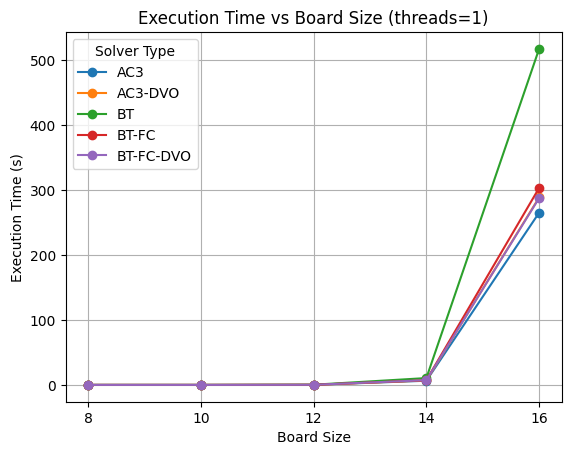

In [12]:
plt.figure()

for solver in solvers:
    
    solverData = sequential_summary_df[sequential_summary_df["solverType"] == solver]
    
    color_to_use = color_map.get(solver, 'black')
    plt.plot(solverData["boardSize"], solverData["timeToAll"], marker="o", label=solver,color=color_to_use)

plt.title("Execution Time vs Board Size (threads=1)")
plt.xlabel("Board Size")
plt.xticks(np.arange(8, 17, 2.0))
plt.ylabel("Execution Time (s)")
plt.legend(title="Solver Type")
plt.grid(True)
plt.show()

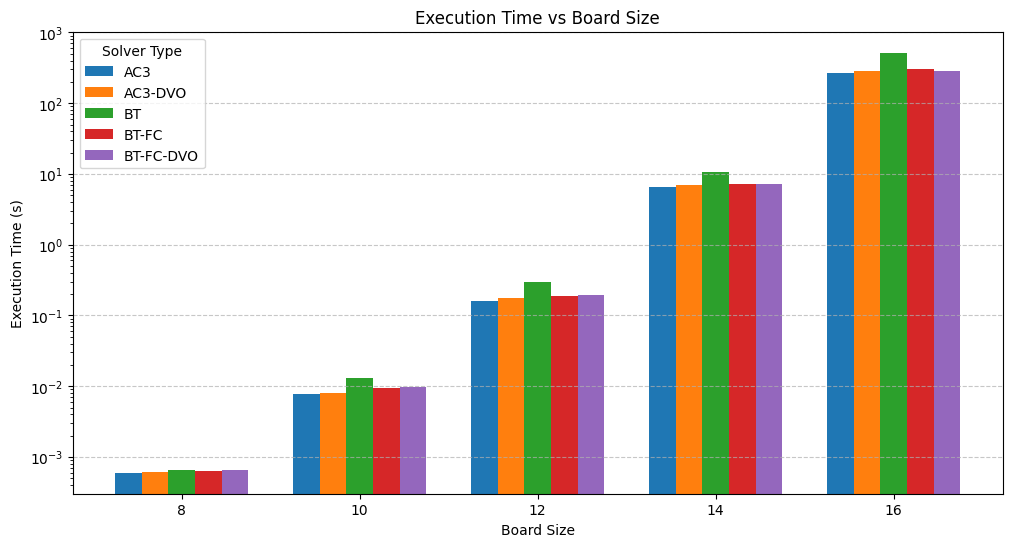

In [13]:
plot_grouped_bar(sequential_summary_df, value_column="timeToAll", x_label="Board Size", y_label="Execution Time (s)", title="Execution Time vs Board Size", color_map=color_map, log_scale=True)

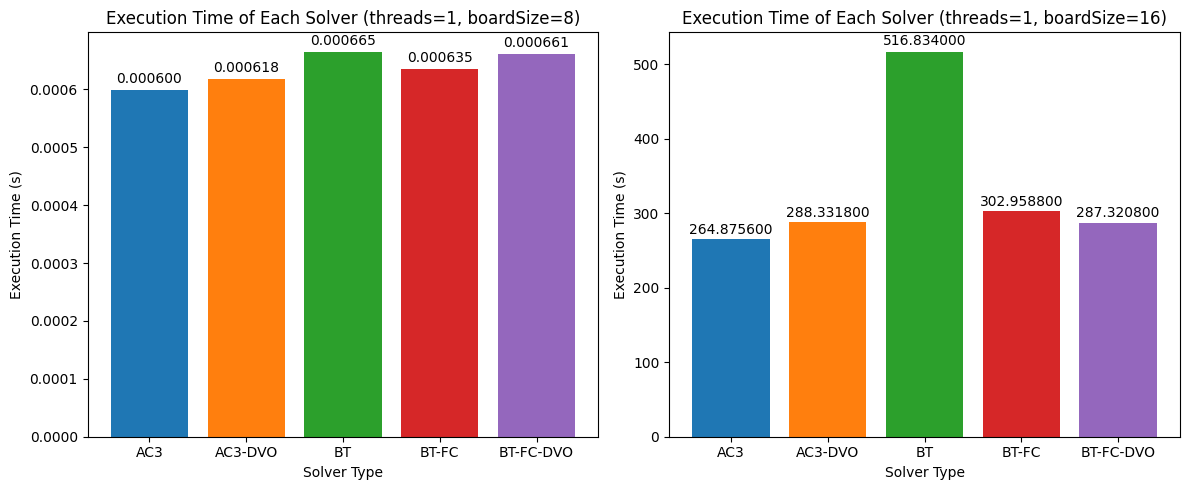

In [14]:
maxBoardSizeData = sequential_summary_df[sequential_summary_df["boardSize"] == sequential_summary_df["boardSize"].max()]
minBoardSizeData = sequential_summary_df[sequential_summary_df["boardSize"] == sequential_summary_df["boardSize"].min()]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

minBars = axes[0].bar(minBoardSizeData['solverType'], minBoardSizeData['timeToAll'], color=[color_map[solver] for solver in minBoardSizeData['solverType']])
axes[0].set_title(f"Execution Time of Each Solver (threads=1, boardSize={sequential_summary_df["boardSize"].min()})")
axes[0].set_xlabel("Solver Type")
axes[0].set_ylabel("Execution Time (s)")

maxBars = axes[1].bar(maxBoardSizeData['solverType'], maxBoardSizeData['timeToAll'], color=[color_map[solver] for solver in maxBoardSizeData['solverType']])
axes[1].set_title(f"Execution Time of Each Solver (threads=1, boardSize={sequential_summary_df["boardSize"].max()})")
axes[1].set_xlabel("Solver Type")
axes[1].set_ylabel("Execution Time (s)")
for bars in [minBars, maxBars]:
    for bar in bars:
        height = bar.get_height()
        bar_axes = bar.axes
        bar_axes.text(bar.get_x() + bar.get_width()/2, height + 0.01*height, f"{height:.6f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Memory

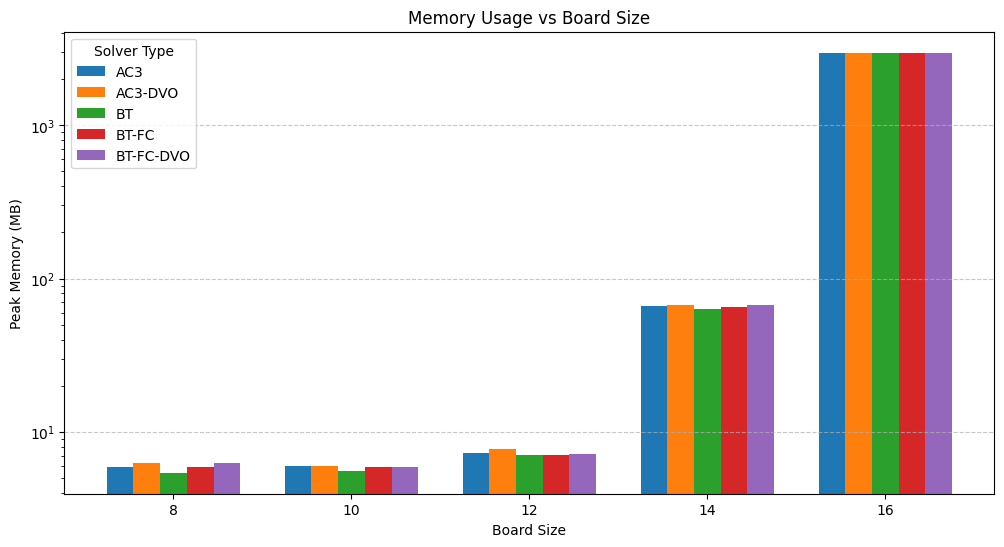

In [15]:
plot_grouped_bar(sequential_summary_df, value_column="peakMemoryMB", x_label="Board Size", y_label="Peak Memory (MB)", title="Memory Usage vs Board Size", color_map=color_map, log_scale=True)

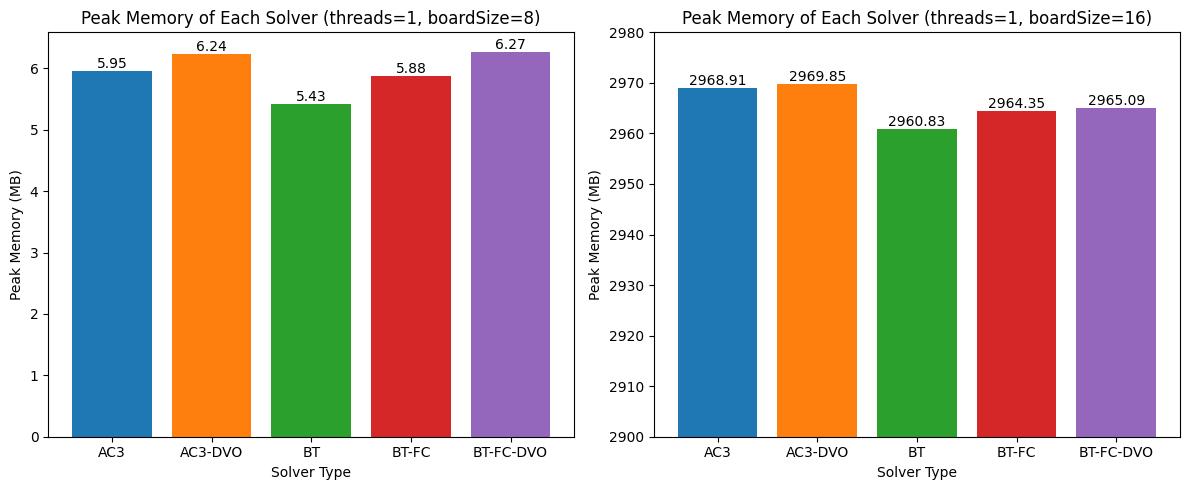

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

minBars = axes[0].bar(minBoardSizeData['solverType'], minBoardSizeData['peakMemoryMB'], color=[color_map[solver] for solver in minBoardSizeData['solverType']])
axes[0].set_title(f"Peak Memory of Each Solver (threads=1, boardSize={sequential_summary_df["boardSize"].min()})")
axes[0].set_xlabel("Solver Type")
axes[0].set_ylabel("Peak Memory (MB)")

maxBars = axes[1].bar(maxBoardSizeData['solverType'], maxBoardSizeData['peakMemoryMB'], color=[color_map[solver] for solver in maxBoardSizeData['solverType']])
axes[1].set_title(f"Peak Memory of Each Solver (threads=1, boardSize={sequential_summary_df["boardSize"].max()})")
axes[1].set_xlabel("Solver Type")
axes[1].set_ylabel("Peak Memory (MB)")
axes[1].set_ylim(bottom=2900, top=2980)

for bars in [minBars, maxBars]:
    for bar in bars:
        height = bar.get_height()
        bar_axes = bar.axes
        bar_axes.text(bar.get_x() + bar.get_width()/2, height, f"{height:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

### CPU usage

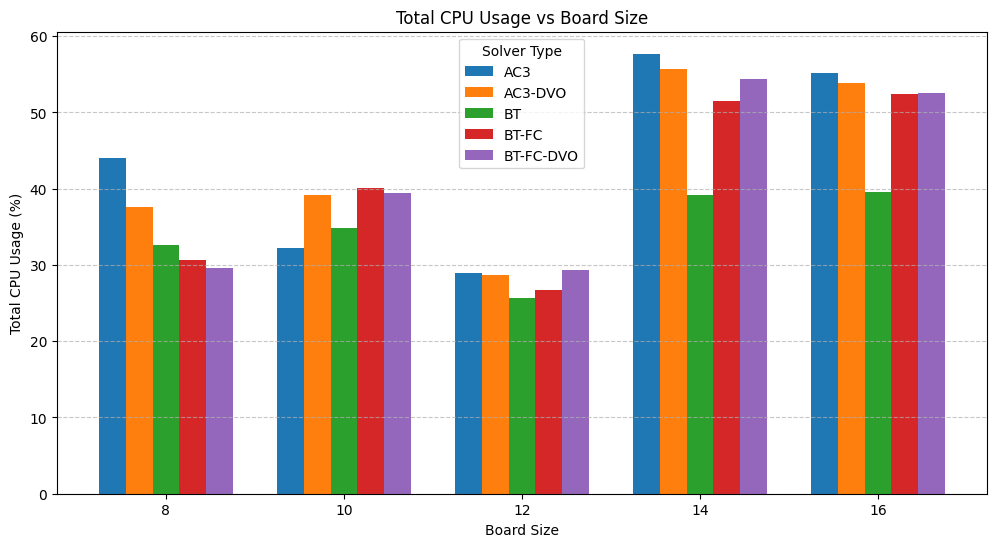

In [17]:
plot_grouped_bar(sequential_summary_df, value_column="cpu_usage_mean", x_label="Board Size", y_label="Total CPU Usage (%)", title="Total CPU Usage vs Board Size", color_map=color_map)

### CPU Power Draw

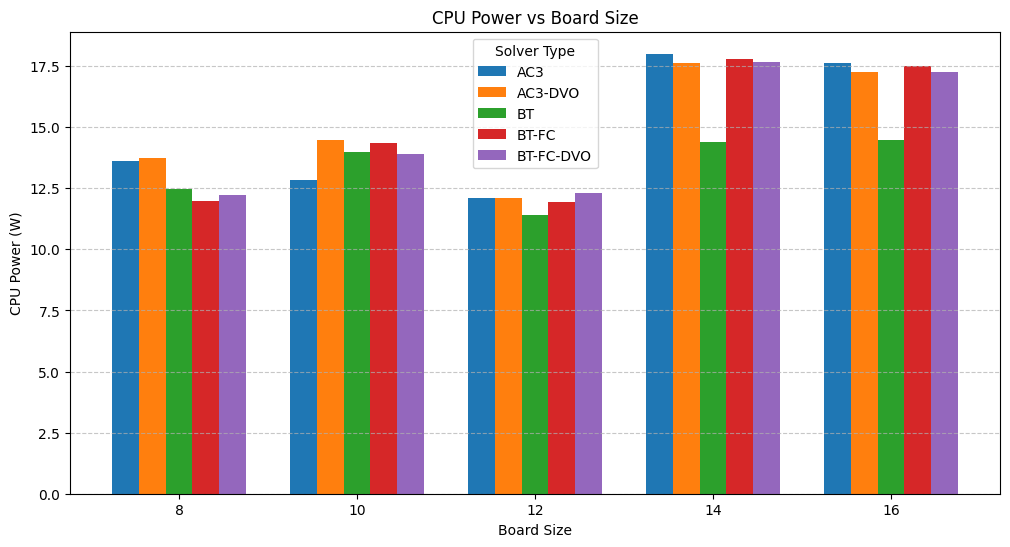

In [18]:
plot_grouped_bar(sequential_summary_df, value_column="power_mean", x_label="Board Size", y_label="CPU Power (W)", title="CPU Power vs Board Size")

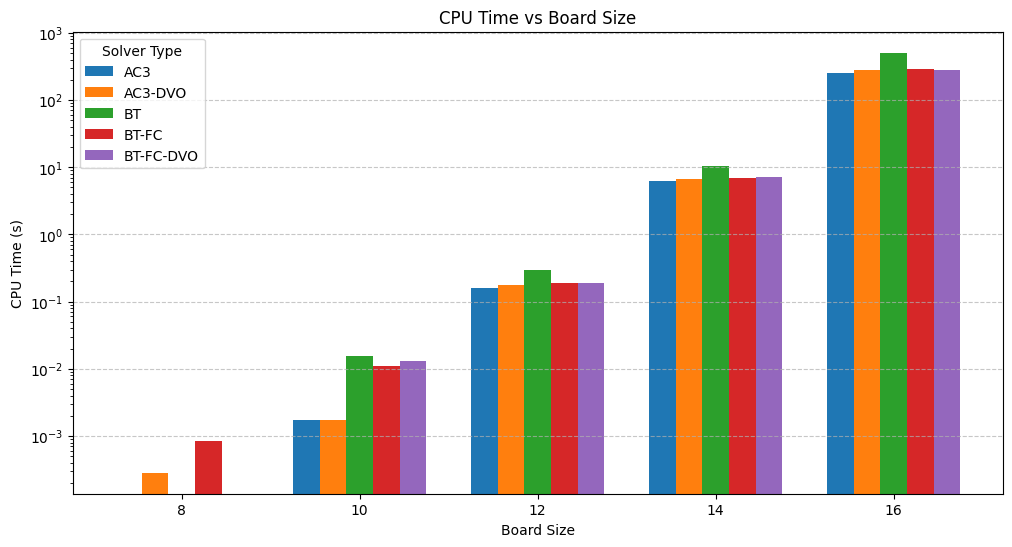

In [19]:
plot_grouped_bar(sequential_summary_df, value_column="cpuTime", x_label="Board Size", y_label="CPU Time (s)", title="CPU Time vs Board Size", log_scale=True)

## PARALLEL

In [20]:
baseline_summary = sequential_summary_df[sequential_summary_df['boardSize'] == 16]
baseline_summary

,solverType,threads,isParallel,boardSize,domainGranularity,timeToFirst,timeToAll,cpuTime,peakMemoryMB,power_mean,cpu_usage_mean,energy_sum
4,AC3,1,0,16,1,0.002520,264.8756,254.9624,2968.906,17.640266,55.237498,4672.656361
9,AC3-DVO,1,0,16,1,0.000501,288.3318,276.2406,2969.852,17.267929,53.855603,4979.186963
14,BT,1,0,16,1,0.004677,516.8340,504.7436,2960.826,14.474529,39.526855,7574.082745
19,BT-FC,1,0,16,1,0.003045,302.9588,291.8564,2964.346,17.501992,52.381537,5303.278827
24,BT-FC-DVO,1,0,16,1,0.000205,287.3208,276.4436,2965.092,17.259271,52.586549,4959.460564


In [21]:
parallel_summary_df = pd.concat([parallel_summary_df, baseline_summary], ignore_index=True)
parallel_summary_df = parallel_summary_df.sort_values(by=['solverType', 'threads'])

### Latency

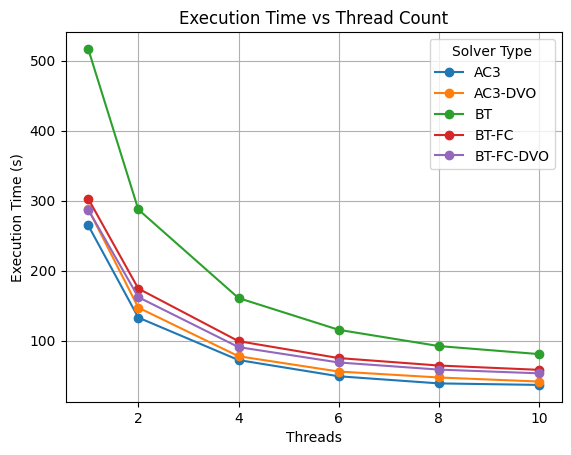

In [22]:
plt.figure()

for solver in solvers:
    
    solverData = parallel_summary_df[parallel_summary_df["solverType"] == solver]
    
    color_to_use = color_map.get(solver, 'black')
    plt.plot(solverData["threads"], solverData["timeToAll"], marker="o", label=solver,color=color_to_use)

plt.title("Execution Time vs Thread Count")
plt.xlabel("Threads")
plt.xticks(np.arange(2, 11, 2.0))
plt.ylabel("Execution Time (s)")
plt.legend(title="Solver Type")
plt.grid(True)
plt.show()

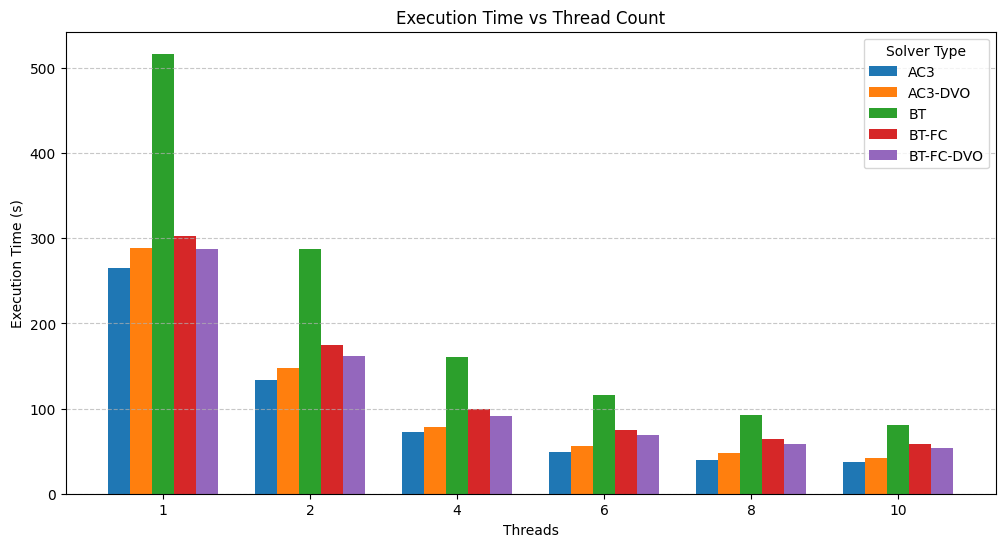

In [23]:
plot_grouped_bar(parallel_summary_df, value_column="timeToAll", x_label="Threads", y_label="Execution Time (s)", title="Execution Time vs Thread Count", color_map=color_map, log_scale=False, group_by="threads")

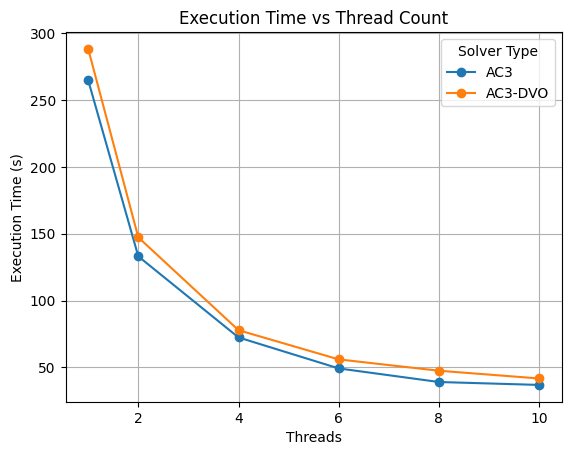

In [33]:
plt.figure()

ac3_ac3dvo = parallel_summary_df[parallel_summary_df['solverType'].isin(['AC3', 'AC3-DVO'])]



for solver in ac3_ac3dvo['solverType'].unique():
    
    solverData = parallel_summary_df[parallel_summary_df["solverType"] == solver]
    
    color_to_use = color_map.get(solver, 'black')
    plt.plot(solverData["threads"], solverData["timeToAll"], marker="o", label=solver,color=color_to_use)

plt.title("Execution Time vs Thread Count")
plt.xlabel("Threads")
plt.xticks(np.arange(2, 11, 2.0))
plt.ylabel("Execution Time (s)")
plt.legend(title="Solver Type")
plt.grid(True)
plt.show()

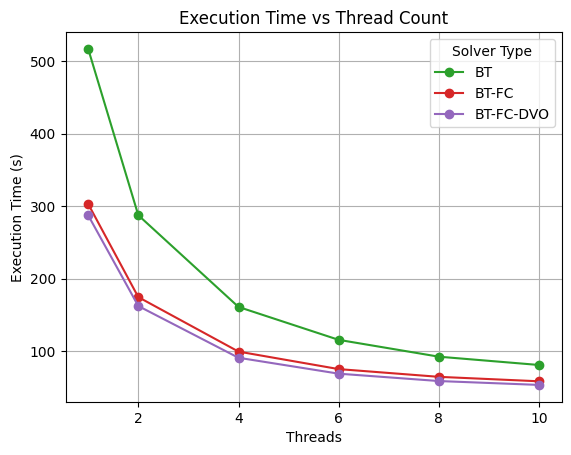

In [37]:
plt.figure()

bt = parallel_summary_df[parallel_summary_df['solverType'].isin(['BT', 'BT-FC', 'BT-FC-DVO'])]



for solver in bt['solverType'].unique():
    
    solverData = parallel_summary_df[parallel_summary_df["solverType"] == solver]
    
    color_to_use = color_map.get(solver, 'black')
    plt.plot(solverData["threads"], solverData["timeToAll"], marker="o", label=solver,color=color_to_use)

plt.title("Execution Time vs Thread Count")
plt.xlabel("Threads")
plt.xticks(np.arange(2, 11, 2.0))
plt.ylabel("Execution Time (s)")
plt.legend(title="Solver Type")
plt.grid(True)
plt.show()

### Memory

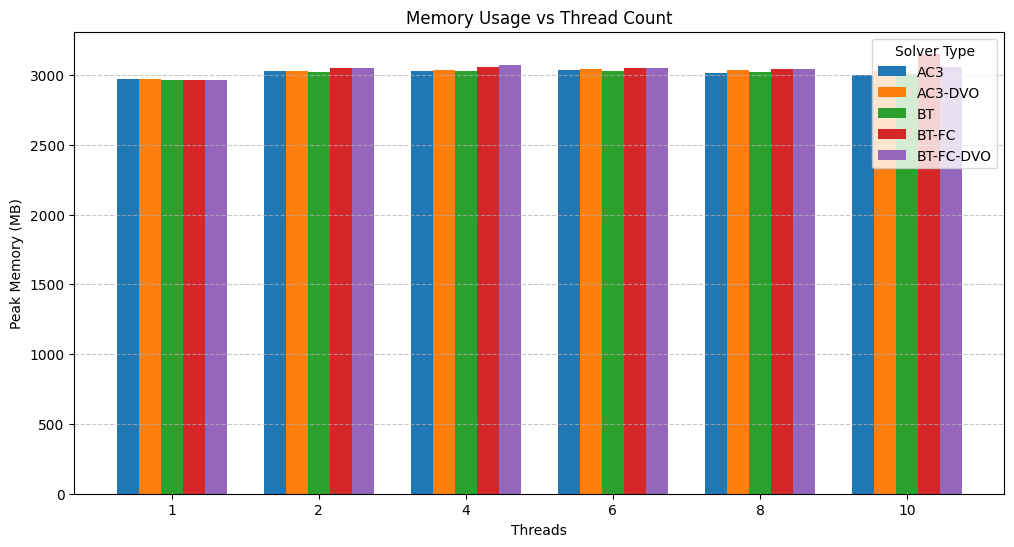

In [25]:
plot_grouped_bar(parallel_summary_df, value_column="peakMemoryMB", x_label="Threads", y_label="Peak Memory (MB)", title="Memory Usage vs Thread Count", color_map=color_map, group_by="threads")

### CPU Usage

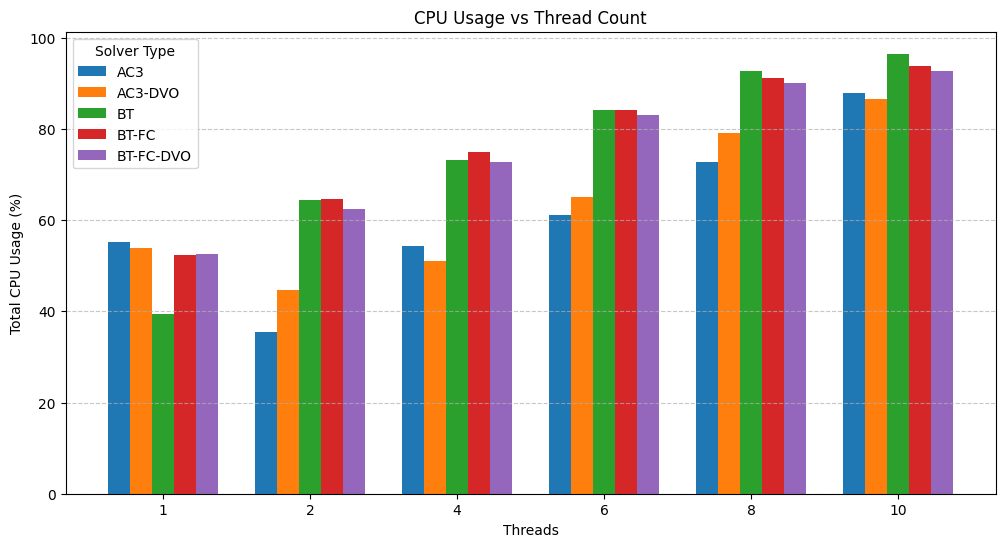

In [26]:
plot_grouped_bar(parallel_summary_df, value_column="cpu_usage_mean", x_label="Threads", y_label="Total CPU Usage (%)", title="CPU Usage vs Thread Count", color_map=color_map, group_by="threads")

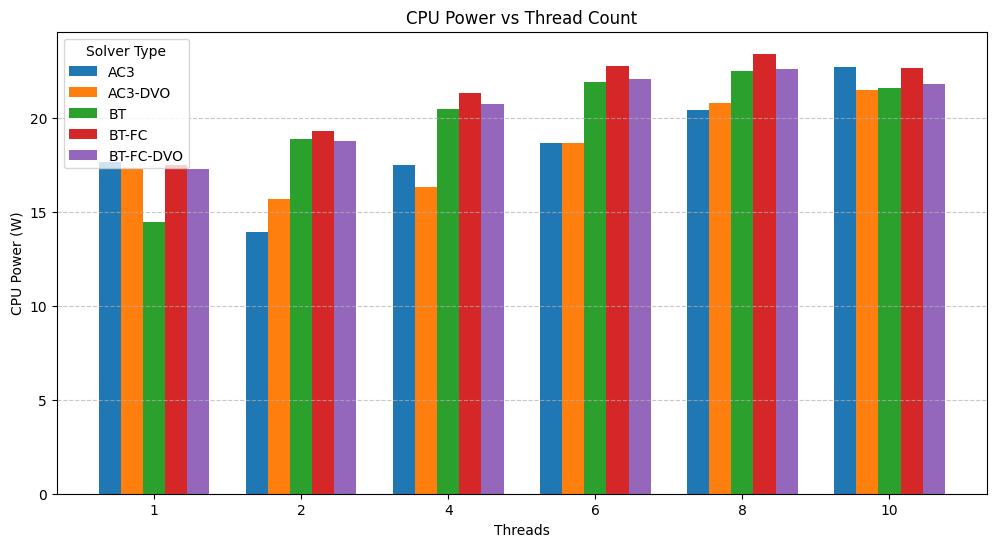

In [27]:
plot_grouped_bar(parallel_summary_df, value_column="power_mean", x_label="Threads", y_label="CPU Power (W)", title="CPU Power vs Thread Count", color_map=color_map, group_by="threads")

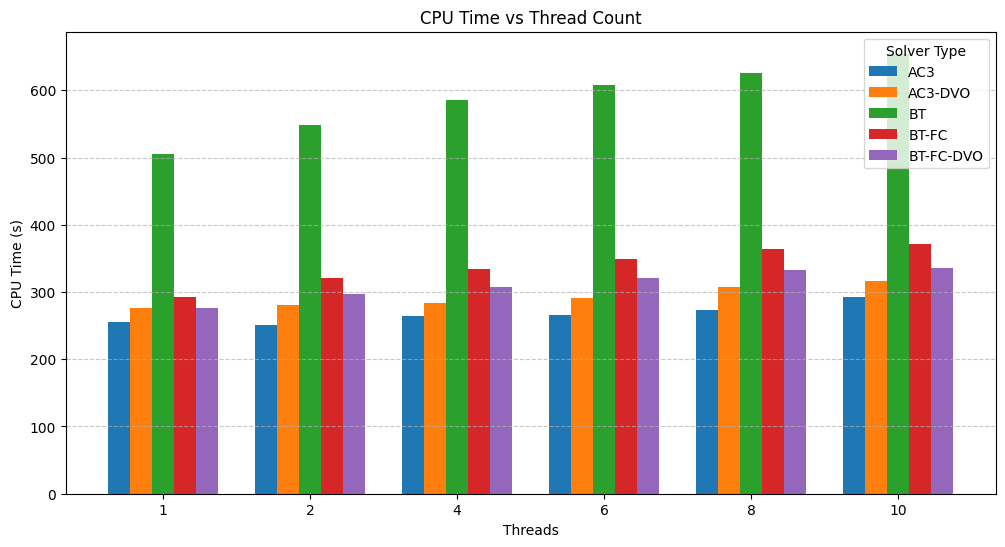

In [28]:
plot_grouped_bar(parallel_summary_df, value_column="cpuTime", x_label="Threads", y_label="CPU Time (s)", title="CPU Time vs Thread Count", group_by="threads")

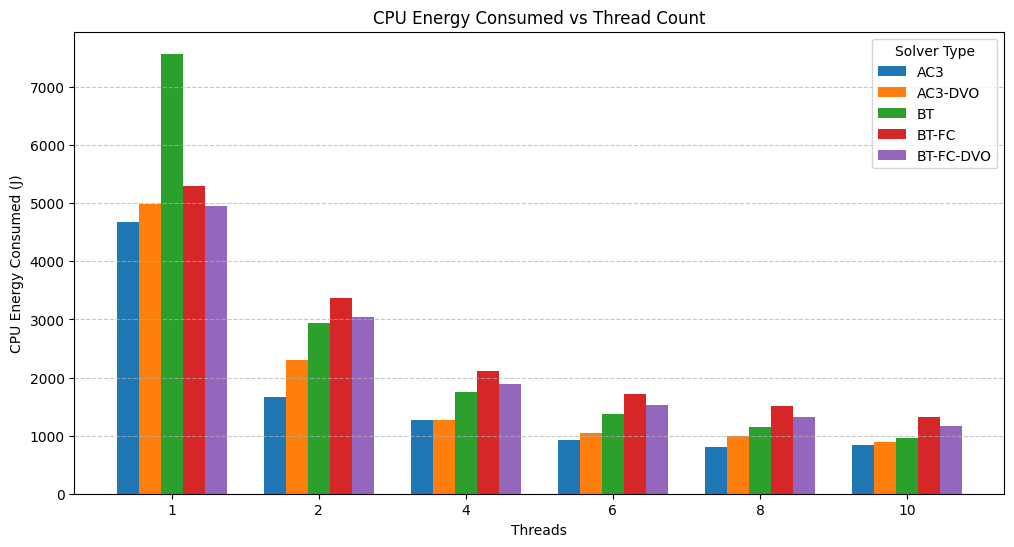

In [29]:
plot_grouped_bar(parallel_summary_df, value_column="energy_sum", x_label="Threads", y_label="CPU Energy Consumed (J)", title="CPU Energy Consumed vs Thread Count", color_map=color_map, group_by="threads")

### Speedup & Efficiency

In [30]:
baseline = sequential_summary_df[['solverType', 'boardSize', 'timeToAll']].rename(columns={'timeToAll': 'seq_time'})

parallel = parallel_summary_df[['solverType', 'boardSize', 'threads', 'timeToAll', 'power_mean', 'energy_sum']].rename(columns={'timeToAll': 'parallel_time', 'energy_sum': 'energy', 'power_mean': 'power'})[parallel_summary_df['threads'] > 1]

merged = parallel.merge(baseline, on=['solverType', 'boardSize']).drop_duplicates()

merged['speedup'] = merged['seq_time'] / merged['parallel_time']
merged['efficiency'] = merged['speedup'] / merged['threads']

merged

,solverType,boardSize,threads,parallel_time,power,energy,seq_time,speedup,efficiency
0,AC3,16,2,133.08560,13.950368,1666.541709,264.8756,1.990265,0.995132
1,AC3,16,4,72.40482,17.466635,1264.814809,264.8756,3.658259,0.914565
2,AC3,16,6,49.21870,18.655111,918.116422,264.8756,5.381605,0.896934
3,AC3,16,8,39.04846,20.439191,798.160407,264.8756,6.783253,0.847907
4,AC3,16,10,36.86794,22.690791,836.781613,264.8756,7.184443,0.718444
5,AC3-DVO,16,2,147.30200,15.665595,2309.386096,288.3318,1.957419,0.978710
6,AC3-DVO,16,4,77.83712,16.303957,1269.264689,288.3318,3.704297,0.926074
7,AC3-DVO,16,6,55.97898,18.652515,1046.565106,288.3318,5.150716,0.858453
8,AC3-DVO,16,8,47.48410,20.785198,986.685545,288.3318,6.072176,0.759022
9,AC3-DVO,16,10,41.69616,21.499324,896.154308,288.3318,6.915068,0.691507


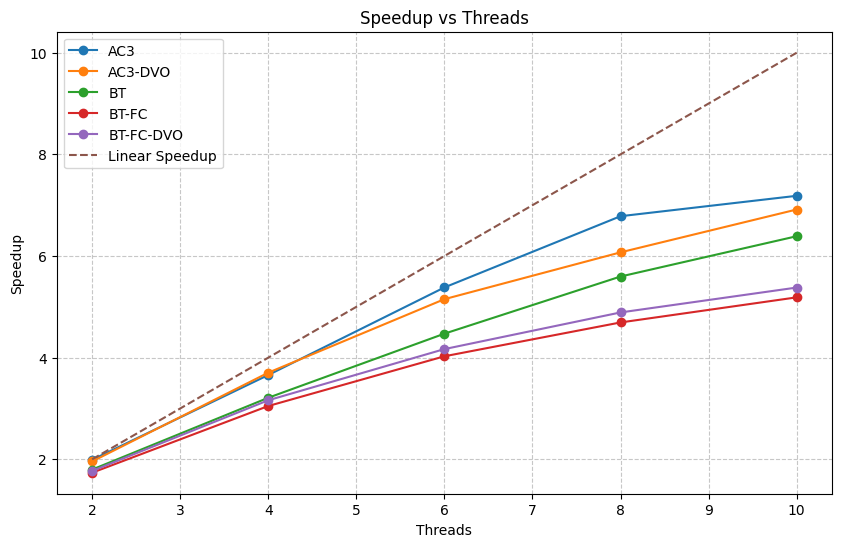

In [31]:
solvers = merged['solverType'].unique()

plt.figure(figsize=(10, 6))

for solver in solvers:
    data = merged[merged['solverType'] == solver]
    plt.plot(data['threads'], data['speedup'], marker='o', label=solver)

threads = sorted(merged['threads'].unique())
plt.plot(threads, threads, linestyle='--', linewidth=1.5, label='Linear Speedup')

plt.xlabel("Threads")
plt.ylabel("Speedup")
plt.title("Speedup vs Threads")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

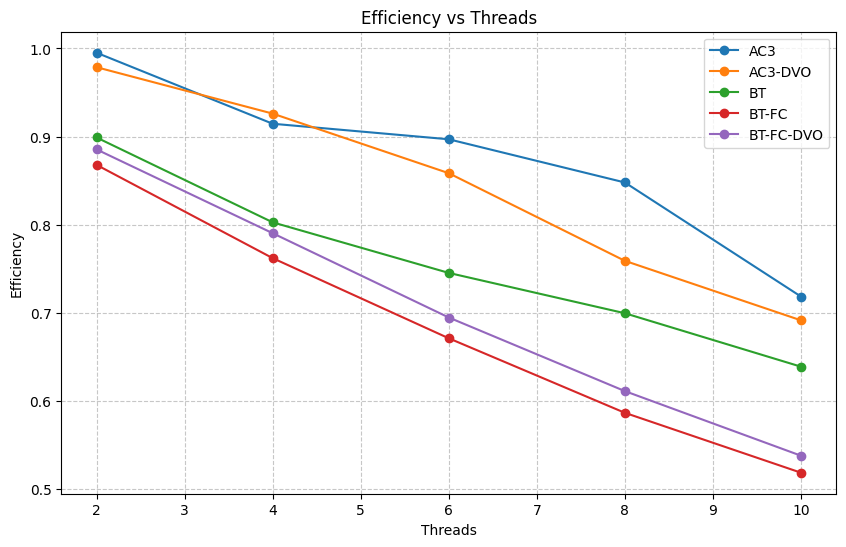

In [32]:
solvers = merged['solverType'].unique()

plt.figure(figsize=(10, 6))
for solver in solvers:
    data = merged[merged['solverType'] == solver]
    plt.plot(data['threads'], data['efficiency'], marker='o', label=solver)

plt.xlabel("Threads")
plt.ylabel("Efficiency")
plt.title("Efficiency vs Threads")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()